In [32]:
import linopy
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from shapely import wkt

In [33]:
xr_ref = xr.open_dataset('Output\\xr_final_SI_exc_r.nc')
print(xr_ref)

<xarray.Dataset>
Dimensions:    (lat: 1782, lon: 995)
Coordinates:
  * lat        (lat) float64 5.618 5.626 5.635 5.643 ... 20.43 20.44 20.45 20.46
  * lon        (lon) float64 97.35 97.36 97.37 97.37 ... 105.6 105.6 105.6 105.6
Data variables:
    SI_Solar   (lat, lon) float32 ...
    SI_Wind    (lat, lon) float32 ...
    AVA_Wind   (lat, lon) float32 ...
    AVA_Solar  (lat, lon) float32 ...
    ADM1_EN    (lat, lon) object ...
    region     (lat, lon) object ...


In [34]:
mwperkm2_wind = 4.5  ## originally 9 MW/km2 but deduct by 50% of the technically available from IEA's Thailand CET
mwperkm2_solar = 15 ## originally 30 MW/km2 but deduct by 50% of the technically available from IEA's Thailand CET
coarsenscale = 3
lccs_resoultion = (300 * coarsenscale /1000) ** 2 ## meters
print(lccs_resoultion)
## max capacity of spp 90 MW
maxcapacityinpolygon_SPP = 90
maxcapacityinpolygon_VSPP = 10

maxnoofgrid_SPP_wind = np.ceil((maxcapacityinpolygon_SPP/(mwperkm2_wind * lccs_resoultion)))
maxnoofgrid_SPP_solar = np.ceil((maxcapacityinpolygon_SPP/(mwperkm2_solar * lccs_resoultion)))

rolling_latlon_SPP_wind = np.ceil(np.sqrt(maxnoofgrid_SPP_wind)).astype('int16')
rolling_latlon_SPP_solar = np.ceil(np.sqrt(maxnoofgrid_SPP_solar)).astype('int16')

if (rolling_latlon_SPP_wind < 3): rolling_latlon_SPP_wind=3
if (rolling_latlon_SPP_solar < 3): rolling_latlon_SPP_solar=3

maxnoofgrid_VSPP_wind = np.ceil((maxcapacityinpolygon_VSPP/(mwperkm2_wind * lccs_resoultion)))
maxnoofgrid_VSPP_solar = np.ceil((maxcapacityinpolygon_VSPP/(mwperkm2_solar * lccs_resoultion)))

rolling_latlon_VSPP_wind = np.ceil(np.sqrt(maxnoofgrid_VSPP_wind)).astype('int16')
rolling_latlon_VSPP_solar = np.ceil(np.sqrt(maxnoofgrid_VSPP_solar)).astype('int16')

if (rolling_latlon_VSPP_wind < 3): rolling_latlon_VSPP_wind=3
if (rolling_latlon_VSPP_solar < 3): rolling_latlon_VSPP_solar=3

print("maxnoofgrid_SPP_wind = ",maxnoofgrid_SPP_wind,"sqrt = ",rolling_latlon_SPP_wind)
print("maxnoofgrid_SPP_solar = ",maxnoofgrid_SPP_solar,"sqrt = ",rolling_latlon_SPP_solar)

print("maxnoofgrid_VSPP_wind = ",maxnoofgrid_VSPP_wind,"sqrt = ",rolling_latlon_VSPP_wind)
print("maxnoofgrid_VSPP_solar = ",maxnoofgrid_VSPP_solar,"sqrt = ",rolling_latlon_VSPP_solar)

0.81
maxnoofgrid_SPP_wind =  25.0 sqrt =  5
maxnoofgrid_SPP_solar =  8.0 sqrt =  3
maxnoofgrid_VSPP_wind =  3.0 sqrt =  3
maxnoofgrid_VSPP_solar =  1.0 sqrt =  3


In [35]:
######################## model #####################################################
m = linopy.Model()

built_solar = m.add_variables(integer=True,upper=1,lower=0, coords=xr_ref.coords, name='built_solar')
built_wind = m.add_variables(integer=True,upper=1,lower=0, coords=xr_ref.coords, name='built_wind')

In [36]:
# constr_built_logic = m.add_constraints(built_solar <= 1, name='built_logic')
# print(constr_built_logic)

In [37]:
constr_rolling = m.add_constraints(
    (
    built_solar.rolling(lat=rolling_latlon_SPP_solar,center=True).sum().rolling(lon=rolling_latlon_SPP_solar,center=True).sum()
    +
    built_wind.rolling(lat=rolling_latlon_SPP_wind,center=True).sum().rolling(lon=rolling_latlon_SPP_wind,center=True).sum()
    ) <= 1 ,name='constr_rolling')


In [38]:
obj = (-1000) * (
    (built_solar * (xr_ref['SI_Solar'].rolling(lat=rolling_latlon_SPP_solar,center=True).sum().rolling(lon=rolling_latlon_SPP_solar,center=True).sum())).sum()
    +(built_wind * (xr_ref['SI_Wind'].rolling(lat=rolling_latlon_SPP_wind,center=True).sum().rolling(lon=rolling_latlon_SPP_wind,center=True).sum())).sum()
)
m.add_objective(obj)

LinearExpression
----------------
+nan built_solar[5.618055555555557, 97.34861111111111] + nan built_solar[5.618055555555557, 97.35694444444447] + nan built_solar[5.618055555555557, 97.36527777777779] ... +nan built_wind[20.459722222222226, 105.61527777777779] + nan built_wind[20.459722222222226, 105.62361111111113] + nan built_wind[20.459722222222226, 105.63194444444446]

In [39]:
print("presolve = ",m)
m.solve(solver_name='highs',
        mip_abs_gap = 0.0018,
        mip_rel_gap = 0.0018,
        )

print('aftersolve = ',m)
solution = m.solution
solution = solution.fillna(0)

presolve =  Linopy ILP model

Variables:
----------
 * built_solar (lat, lon)
 * built_wind (lat, lon)

Constraints:
------------
 * constr_rolling (lat, lon)

Status:
-------
initialized


Writing integer variables.: 100%|██████████| 2/2 [00:03<00:00,  1.95s/it]


In [ ]:
print(solution)

<xarray.Dataset>
Dimensions:      (lat: 1782, lon: 995)
Coordinates:
  * lat          (lat) float64 5.618 5.626 5.635 5.643 ... 20.44 20.45 20.46
  * lon          (lon) float64 97.35 97.36 97.37 97.37 ... 105.6 105.6 105.6
Data variables:
    built_solar  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    built_wind   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0


In [ ]:
print(solution['built_solar'].sum())

<xarray.DataArray 'built_solar' ()>
array(27391.)


In [ ]:
## First, I try to create a bouadary of THialand for acquiring data##
thailandmap = gpd.read_file('Data\\tha_admbnda_adm1_rtsd_20220121\\tha_admbnda_adm1_rtsd_20220121.shp')
thailandmap.crs = {'init': 'epsg:4326'}
province = "หนองคาย"
thailandmap = thailandmap.loc[thailandmap['ADM1_TH'] == province]
print(thailandmap.unary_union.bounds)
min_lon = thailandmap.unary_union.bounds[0]
max_lon = thailandmap.unary_union.bounds[2]
max_lat = thailandmap.unary_union.bounds[1]
min_lat = thailandmap.unary_union.bounds[3]

(102.05513989400004, 17.593768951000072, 103.41287009700005, 18.305247632000032)


C:\Users\basna\AppData\Roaming\Python\Python311\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [ ]:
solution = solution.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon))

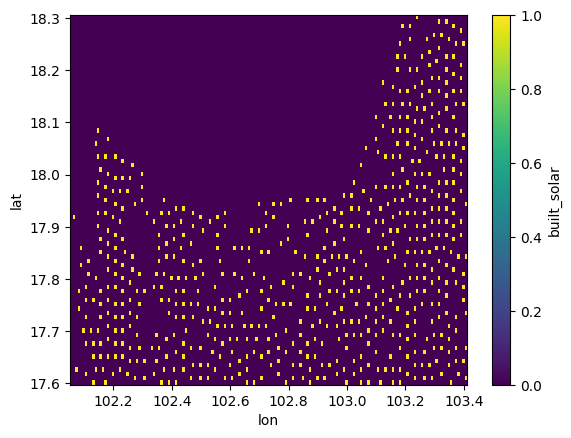

In [ ]:
solution['built_solar'].plot()